#Задача: Оптимизировать нейросеть

Это решение расположено в репозитории https://github.com/crazyelf1971/odb21/

##Описание задачи

https://open-data-battle.geecko.com/issues/predict

В одной из компаний для найма сотрудников решили создать математическую модель, описывающую зависимость уровня заработной платы от опыта сотрудников. В файлах ‘inputs.npy’, ‘outputs.npy’ даны оценки заработной платы и опыта сотрудников, представленные в своих диапазонах и полученные в результате использования шкалы перевода.

В компании разработали простейшую нейронную сеть model с ошибкой loss. Обучи нейронную сеть предсказывать необходимые значения. В качестве ответа к заданию предскажи 5 точек [1, 2, 3, 4, 5] при помощи нейронной сети любой модели. Ответ выдайте в формате JSON:


{
  "answer": ["x1", "x2", "x3", ... , "x5"]
}
   

##Скачивание данных

Если ссылка на соревнование перестанет быть актуальной, можно будет взять файлы из моего репозитория с решениями https://github.com/crazyelf1971/odb21  
При запуске не из Google Colab можно использовать для скачки библиотеку wget и вызовы os.system, либо просто взять готовые npy файлы из репозитория и пропустить этот шаг.

In [1]:
import gdown

file_name = gdown.download('https://open-data-battle.geecko.com/dataset/predict.zip',None, False)
!unzip {file_name}
!ls -la *.npy

Downloading...
From: https://open-data-battle.geecko.com/dataset/predict.zip
To: /content/predict.zip
7.96kB [00:00, 4.56MB/s]                   

Archive:  predict.zip
  inflating: inputs.npy              
  inflating: outputs.npy             


-rw-r--r-- 1 root root 4128 Aug 24 05:38 inputs.npy
-rw-r--r-- 1 root root 4128 Aug 24 05:38 outputs.npy


##Загрузка данных

In [2]:
import numpy as np

inputs = np.load('inputs.npy')
outputs = np.load('outputs.npy')
print(inputs.shape, outputs.shape)

(1000,) (1000,)


##Визуализация данных

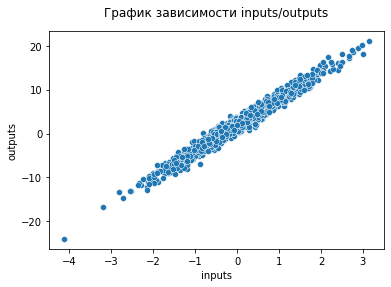

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=inputs, y=outputs);
plt.xlabel('inputs')
plt.ylabel('outputs')
plt.title('График зависимости inputs/outputs', pad=15);

Как видно из графика, зависимость практически линейная.

##Заготовка нейросети из задания

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Модель
class myModel(object):
  def __init__(self):
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(10.0)

  def __call__(self, x):
    return self.W * x + self.b

model = myModel()

# Ошибка
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

Current loss: 64.425949


На первый взгляд, ошибка довольно большая для таких простых данных.  
Нужно оптимизировать данную нейросеть, чтобы получить предсказание поточнее.

##Решение задачи

- добавим возможность задавать коэффициенты модели при её инициализации вместо жёсткой прошивки коэффициентов в коде модели
- после чего переберём небольшой диапазон возможных значений коэффициентов (поскольку визуально график зависимости проходит примерно через точки (0,0) и (2, 10), то множитель будет лежать близко к 5, а сдвиг близко к 0)

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Модель
class myModel(object):
  def __init__(self, W, b):
    self.W = tf.Variable(W)
    self.b = tf.Variable(b)

  def __call__(self, x):
    return self.W * x + self.b

# Ошибка
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

scores = []
for w in np.arange(3, 8, 0.25):
    for b in np.arange(-2, 3, 0.25):
        model = myModel(w, b)
        scores.append((loss(model(inputs), outputs).numpy(), w, b))

s, *k = min(scores)
print(f'Минимум потерь достигается в точке: {k}, loss: {s:.3f}')

Минимум потерь достигается в точке: [6.0, 2.0], loss: 1.045


##Предсказание

Инициализируем модель найденными нами оптимальными параметрами и предскажем значения в требуемых точках.

In [6]:
model = myModel(*k)
X = [1, 2, 3, 4, 5]
y = model(X)
y = list(y.numpy().astype(int))
y_str = '","'.join(map(str, y))
print(f'''
{{
    "answer": ["{y_str}"]
}} 
''')


{
    "answer": ["8","14","20","26","32"]
} 

